# Анализ рынка игр для интернет-магазина "Стримчик"

## Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.


Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.


В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Описание данных
* `Name` — название игры
* `Platform` — платформа
* `Year_of_Release` — год выпуска
* `Genre` — жанр игры
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
* `EU_sales` — продажи в Европе (миллионы проданных копий)
* `JP_sales` — продажи в Японии (миллионы проданных копий)
* `Other_sales` — продажи в других странах (миллионы проданных копий)
* `Critic_Score` — оценка критиков (максимум 100)
* `User_Score` — оценка пользователей (максимум 10)
* `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

## Импорт библиотек и настроек

In [2]:
import warnings
warnings.simplefilter('ignore')


import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import matplotlib


from pylab import rcParams 

%config InlineBackend.figure_format = 'svg'
sns.set_theme(style='whitegrid')

import warnings
warnings.simplefilter('ignore')

pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', 0)
#pd.set_option('float_format', '{:f}'.format)
pd.options.display.float_format = '{:.2f}'.format


import missingno
%matplotlib inline
rcParams['figure.figsize'] =14, 7


#from pandas_profiling import ProfileReport
from ydata_profiling import ProfileReport

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [2]:
try: 
    os.path.exists('/datasets/games.csv')
    df_raw = pd.read_csv('/datasets/games.csv')
except:
    df_raw = pd.read_csv('./games.csv')
df = df_raw.copy()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
pd.concat([df.isna().sum().to_frame().rename(columns = {0:'Количество пропусков'}),
          round((df.isna().mean().to_frame()*100).rename(columns = {0:'Процент пропусков'}), 2)], axis=1)

,Количество пропусков,Процент пропусков
Name,2,0.01
Platform,0,0.00
Year_of_Release,269,1.61
Genre,2,0.01
NA_sales,0,0.00
EU_sales,0,0.00
JP_sales,0,0.00
Other_sales,0,0.00
Critic_Score,8578,51.32
User_Score,6701,40.09


In [5]:
# поиск неявных дубликатов
df.duplicated().sum()

0

In [6]:
df[df.duplicated(subset=['Name', 'Platform'],keep=False) == True]

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
604,Madden NFL 13,PS3,2012.00,Sports,2.11,0.22,0.00,0.23,83.00,5.5,E
659,NaN,GEN,1993.00,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
1190,Need for Speed: Most Wanted,X360,2012.00,Racing,0.62,0.78,0.01,0.15,83.00,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.00,Racing,1.00,0.13,0.02,0.10,83.00,8.5,T
1745,Sonic the Hedgehog,PS3,2006.00,Platform,0.41,0.06,0.04,0.66,43.00,4.1,E10+
4127,Sonic the Hedgehog,PS3,NaN,Platform,0.00,0.48,0.00,0.00,43.00,4.1,E10+
5972,Need for Speed: Most Wanted,PC,2005.00,Racing,0.02,0.23,0.00,0.04,82.00,8.5,T
11715,Need for Speed: Most Wanted,PC,2012.00,Racing,0.00,0.06,0.00,0.02,82.00,8.5,T
14244,NaN,GEN,1993.00,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.00,Sports,0.00,0.01,0.00,0.00,83.00,5.5,E


In [7]:
df.duplicated(subset=['Name', 'Platform'], keep=False).sum()

10

In [8]:
df[df.duplicated(subset=['Name', 'Platform', 'Year_of_Release'],keep=False) == True]

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
604,Madden NFL 13,PS3,2012.00,Sports,2.11,0.22,0.00,0.23,83.00,5.5,E
659,NaN,GEN,1993.00,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.00,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.00,Sports,0.00,0.01,0.00,0.00,83.00,5.5,E


In [9]:
#Удалим дубликаты: 
df.drop_duplicates(subset=['Name', 'Platform', 'Year_of_Release'], inplace=True)

#### Вывод
Всего датафрейм на `16715` строк и `11` столбцов, в `5` столбцах есть пропуски, при этом есть два столбца с условно незначительным количеством пропусков - `Name` и `Year_of_Release`, а также три столбца со значительным количеством пропусков - `Critic_Score`, `User_Score`, `Rating`

Неявных дубликатов по всему датафрейму не выявлено, но есть неявные дубликаты по столбцам `Name` и `Platform`

Плюс в некоторых столбцах можно поменять тип данных

## Шаг 2. Подготовьте данные

### 2.1 Замените названия столбцов 
(приведите к нижнему регистру);

In [10]:
df.columns = df.columns.str.lower()

### 2.2 Преобразуйте данные в нужные типы. 
Опишите, в каких столбцах заменили тип данных и почему;

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16712 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       10013 non-null  object 
 10  rating           9948 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


In [12]:
df['user_score'].unique().tolist()

['8',
 nan,
 '8.3',
 '8.5',
 '6.6',
 '8.4',
 '8.6',
 '7.7',
 '6.3',
 '7.4',
 '8.2',
 '9',
 '7.9',
 '8.1',
 '8.7',
 '7.1',
 '3.4',
 '5.3',
 '4.8',
 '3.2',
 '8.9',
 '6.4',
 '7.8',
 '7.5',
 '2.6',
 '7.2',
 '9.2',
 '7',
 '7.3',
 '4.3',
 '7.6',
 '5.7',
 '5',
 '9.1',
 '6.5',
 'tbd',
 '8.8',
 '6.9',
 '9.4',
 '6.8',
 '6.1',
 '6.7',
 '5.4',
 '4',
 '4.9',
 '4.5',
 '9.3',
 '6.2',
 '4.2',
 '6',
 '3.7',
 '4.1',
 '5.8',
 '5.6',
 '5.5',
 '4.4',
 '4.6',
 '5.9',
 '3.9',
 '3.1',
 '2.9',
 '5.2',
 '3.3',
 '4.7',
 '5.1',
 '3.5',
 '2.5',
 '1.9',
 '3',
 '2.7',
 '2.2',
 '2',
 '9.5',
 '2.1',
 '3.6',
 '2.8',
 '1.8',
 '3.8',
 '0',
 '1.6',
 '9.6',
 '2.4',
 '1.7',
 '1.1',
 '0.3',
 '1.5',
 '0.7',
 '1.2',
 '2.3',
 '0.5',
 '1.3',
 '0.2',
 '0.6',
 '1.4',
 '0.9',
 '1',
 '9.7']

In [13]:
df['year_of_release'].unique().tolist()

[2006.0,
 1985.0,
 2008.0,
 2009.0,
 1996.0,
 1989.0,
 1984.0,
 2005.0,
 1999.0,
 2007.0,
 2010.0,
 2013.0,
 2004.0,
 1990.0,
 1988.0,
 2002.0,
 2001.0,
 2011.0,
 1998.0,
 2015.0,
 2012.0,
 2014.0,
 1992.0,
 1997.0,
 1993.0,
 1994.0,
 1982.0,
 2016.0,
 2003.0,
 1986.0,
 2000.0,
 nan,
 1995.0,
 1991.0,
 1981.0,
 1987.0,
 1980.0,
 1983.0]

На первый взгляд можно поменять тип данных в следующих столбцах: 

* `year_of_release` - с `float64` на `int64`, но мешают наны
* `user_score` - c `object` на `float64`, но есть строковое значение `tbd`

Поэтому, сначала попробуем восстановить или удалить данные, а потом вернемся к типу данных


### 2.3 Обработайте пропуски при необходимости:

* Объясните, почему заполнили пропуски определённым образом или почему не стали это делать;
* Опишите причины, которые могли привести к пропускам;
* Обратите внимание на аббревиатуру 'tbd' в столбце с оценкой пользователей. Отдельно разберите это значение и опишите, как его обработать;

In [14]:
pd.concat([df.isna().sum().to_frame().rename(columns = {0:'Количество пропусков'}),
          round((df.isna().mean().to_frame()*100).rename(columns = {0:'Процент пропусков'}), 2)], axis=1)

,Количество пропусков,Процент пропусков
name,1,0.01
platform,0,0.00
year_of_release,269,1.61
genre,1,0.01
na_sales,0,0.00
eu_sales,0,0.00
jp_sales,0,0.00
other_sales,0,0.00
critic_score,8577,51.32
user_score,6700,40.09


#### 2.3.1 Пропуски `name`

In [15]:
#Посмотрим на пропуски в столбце `name`:
df[df['name'].isna() == True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.00,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN


In [16]:
#В данных строчках пропуски почти во всех столбцах, воссстановить их нет возможности, поэтому просто удалим их
df.dropna(subset=['name'], inplace=True)

#### 2.3.2 Пропуски `yaer_of_release`

In [17]:
#Посмотрим на пропуски в столбце `yaer_of_release`:
df[df['year_of_release'].isna()].head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.00,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.00,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.00,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.00,0.21,92.00,8.2,T
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73.00,tbd,E
678,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,1.51,0.61,0.00,0.21,78.00,6.6,E10+
719,Call of Duty 3,Wii,NaN,Shooter,1.17,0.84,0.00,0.23,69.00,6.7,T
805,Rock Band,Wii,NaN,Misc,1.33,0.56,0.00,0.20,80.00,6.3,T


Тут некоторые данные можно было бы попробовать спасти, например:
1) подтянуть год отталкиваясь от названия спортивных игр, с указанным годом/сезоном
2) подтянуть названия исходя из релизов на других платформах(рискованно)

Посмотрим на примеры двух вариантов:

In [18]:
# 1. спортивные игры
df[df['name'] == 'FIFA Soccer 2004']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.00,6.4,E
2606,FIFA Soccer 2004,XB,2003.00,Sports,0.24,0.49,0.00,0.05,82.00,8.2,E
12029,FIFA Soccer 2004,GC,2003.00,Sports,0.05,0.01,0.00,0.00,83.00,6.2,E
13086,FIFA Soccer 2004,GBA,2003.00,Sports,0.04,0.01,0.00,0.00,82.00,7.9,E


In [19]:
# 2.если год релиза на другой платформе = пропущенный год релиза на нужной платформе
df[df['name'] == 'Call of Duty 3']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
557,Call of Duty 3,X360,2006.00,Shooter,1.49,0.92,0.02,0.27,82.00,6.5,T
719,Call of Duty 3,Wii,NaN,Shooter,1.17,0.84,0.00,0.23,69.00,6.7,T
1255,Call of Duty 3,PS3,2006.00,Shooter,0.60,0.62,0.03,0.26,80.00,6.9,T
1915,Call of Duty 3,PS2,2006.00,Shooter,0.89,0.03,0.00,0.15,82.00,7.4,T


1) Ну, касаемо года релиза `FIFA Soccer 2004` скорее всего да, на `PS2` релиз был в 2003, но я думаю, что в случае спортивных игр с указанным годом, можно найти игры, когда у разных платформ год релиза игры будет отличаться 

In [20]:
# пруф
df[df['name'] == 'ESPN NFL Primetime 2002']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
11322,ESPN NFL Primetime 2002,PS2,2001.00,Sports,0.04,0.03,0.00,0.01,65.00,tbd,E
15693,ESPN NFL Primetime 2002,XB,2002.00,Sports,0.01,0.00,0.00,0.00,57.00,tbd,E


2) Ок, подтягивать пропущенный год, исходя из названия спортивной игры выглядит не очень разумным, скорее всего, подтягивать год релиза для определенной платформы с других строк тоже не надежно, убедимся в этом:

In [21]:
# ок, посмотрим на разнообразие игр, когда год релиза не одинаковый:
multi_years = df.groupby(['name']).year_of_release.nunique().gt(1)

display(df.loc[df.name.isin(multi_years[multi_years].index)].sort_values(by='name').head(10))
print('А всего таких строк:', len(df.loc[df.name.isin(multi_years[multi_years].index)].sort_values(by='name')
          ),'\nА сколько процентов таких вот строк, когда вариативность года релиза для определенной игры больше 1:', 
          round(len(df.loc[df.name.isin(multi_years[multi_years].index)].sort_values(by='name')) / len(df)* 100, 2),'%')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15091,11eyes: CrossOver,X360,2009.00,Adventure,0.00,0.00,0.02,0.00,NaN,NaN,NaN
15656,11eyes: CrossOver,PSP,2010.00,Adventure,0.00,0.00,0.02,0.00,NaN,NaN,NaN
10076,18 Wheeler: American Pro Trucker,GC,2002.00,Racing,0.09,0.02,0.00,0.00,52.00,6.8,E
4805,18 Wheeler: American Pro Trucker,PS2,2001.00,Racing,0.20,0.15,0.00,0.05,61.00,5.7,E
3761,2 in 1 Combo Pack: Sonic Heroes / Super Monkey Ball Deluxe,XB,2004.00,Misc,0.40,0.11,0.00,0.02,NaN,NaN,NaN
9966,2 in 1 Combo Pack: Sonic Heroes / Super Monkey Ball Deluxe,X360,2013.00,Misc,0.09,0.01,0.00,0.01,NaN,NaN,NaN
13605,428: Fuusa Sareta Shibuya de,PSP,2009.00,Adventure,0.00,0.00,0.04,0.00,NaN,NaN,NaN
15237,428: Fuusa Sareta Shibuya de,PS3,2009.00,Adventure,0.00,0.00,0.02,0.00,NaN,NaN,NaN
9599,428: Fuusa Sareta Shibuya de,Wii,2008.00,Adventure,0.00,0.00,0.13,0.00,NaN,NaN,NaN
9235,4x4 EVO 2,GC,2002.00,Racing,0.11,0.03,0.00,0.00,56.00,tbd,E


А всего таких строк: 1890 
А сколько процентов таких вот строк, когда вариативность года релиза для определенной игры больше 1: 11.31 %


In [22]:
#уникальный наименований игр с таким условием 
len(df.loc[df.name.isin(multi_years[multi_years].index)]['name'].unique())



694

In [23]:
#Посмотрим, к каким платформам относятся пропуски: 
df[df['year_of_release'].isna()].groupby('platform')['platform'].count().sort_values(ascending=False)

platform
PS2     34
Wii     34
DS      30
X360    30
PS3     25
XB      21
2600    17
PC      17
PSP     16
GC      14
GBA     11
3DS     8 
PS      7 
N64     3 
GB      1 
PSV     1 
Name: platform, dtype: int64

Думаю, учитывая, что таких данных меньше `2%` и затруднительность их восстановления, стоит их просто удалить:

In [24]:
df.shape

(16712, 11)

In [25]:
df.dropna(subset=['year_of_release'], inplace = True)

In [26]:
df.shape

(16443, 11)

##### Вывод
Мы удалили строки с пропусками в `year_of_release`, их было <2%, восстановить их мы не смогли. Однозначно сказать причины появленния данных строк сложно, но можно увидеть, что год релиза игры часто пропущен у Японских платформеров, возможно пропуски в `year_of_release` как то связан с пропусками в `critic_score`, `user_score`

#### 2.3.3 Пропуски `critic_score`, `user_score`, `rating`
У трех столбцов очень большое количество пропусков и схожий характер значения, думаю, что их можно рассматривать одновременно: 

In [27]:
pd.concat([df.isna().sum().to_frame().rename(columns = {0:'Количество пропусков'}),
          round((df.isna().mean().to_frame()*100).rename(columns = {0:'Процент пропусков'}), 2)], axis=1)

,Количество пропусков,Процент пропусков
name,0,0.00
platform,0,0.00
year_of_release,0,0.00
genre,0,0.00
na_sales,0,0.00
eu_sales,0,0.00
jp_sales,0,0.00
other_sales,0,0.00
critic_score,8461,51.46
user_score,6605,40.17


In [28]:
# посмотрим на значения в `critic_score`
df['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

In [29]:
# посмотрим на значения в `rating`
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [30]:
# посмотрим на значения в `user_score`
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В столбце `critic_score` и `rating` все значения, кроме `nan`, нас устраивают, а в столбце `user_score` кроме`nan` есть еще значение `tbd`, если погуглить, то -> TBD - аббревиатура от английского To Be Determined (будет определено) или To Be Decided (будет решено) -> а согласно вводным данным, мы знаем, что данные за 2016 год могут быть неполными, поэтому проверим, может, `tbd` преимущественно хранится в 2016 году? 

In [31]:
pd.merge(
    df[df['user_score'] == 'tbd']
        .groupby(by='year_of_release')['name']
        .count()
        .reset_index()
        .rename(columns={'name': 'tbd_count'}),

    (df[df['user_score'] == 'tbd']
        .groupby(by='year_of_release')['name']
        .count()/df.groupby(by='year_of_release')['name']
        .count() * 100)
        .dropna()
        .reset_index()
        .rename(columns={'name': 'tbd_percent'}),on='year_of_release'
    ).sort_values(by='tbd_percent', ascending=False)


,year_of_release,tbd_count,tbd_percent
11,2009.00,405,28.40
12,2010.00,331,26.37
4,2002.00,192,23.16
10,2008.00,326,22.85
13,2011.00,217,19.10
3,2001.00,82,17.01
9,2007.00,192,16.04
6,2004.00,107,14.04
7,2005.00,121,12.89
8,2006.00,124,12.33


Странно, но значений `tbd` больше всего в `2009` и `2010` году, посмотрим на `2009` год:

In [32]:
df[(df['year_of_release'] == 2009) & (df['user_score'] == 'tbd')].head(15)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
726,Dance Dance Revolution X2,PS2,2009.00,Simulation,1.09,0.85,0.00,0.28,NaN,tbd,E10+
1070,Game Party 3,Wii,2009.00,Puzzle,1.40,0.16,0.00,0.12,37.00,tbd,E
1284,Disney Sing It: Pop Hits,Wii,2009.00,Misc,1.07,0.28,0.00,0.13,NaN,tbd,E
1707,LEGO Indiana Jones 2: The Adventure Continues,DS,2009.00,Action,0.65,0.42,0.00,0.11,59.00,tbd,E
1803,EA Sports Active: More Workouts,Wii,2009.00,Sports,0.76,0.27,0.00,0.10,80.00,tbd,E
1929,MySims Agents,DS,2009.00,Adventure,0.54,0.42,0.00,0.11,60.00,tbd,E
2043,Disney Fairies: Tinker Bell and the Lost Treasure,DS,2009.00,Adventure,0.56,0.34,0.02,0.09,NaN,tbd,E
2092,Cars: Race-O-Rama,Wii,2009.00,Racing,0.61,0.29,0.00,0.09,58.00,tbd,E
2412,Wizards of Waverly Place,DS,2009.00,Misc,0.59,0.20,0.00,0.08,58.00,tbd,E
2565,Deca Sports 2,Wii,2009.00,Sports,0.31,0.33,0.09,0.07,49.00,tbd,E


In [33]:
missing_from_the_past = pd.concat([df[df['user_score'] == 'tbd'].isna().sum().to_frame().rename(columns = {0:'Количество пропусков'}),
          round((df[df['user_score'] == 'tbd'].isna().mean().to_frame()*100).rename(columns = {0:'Процент пропусков'}), 2)], axis=1)

Природа таких значений мне не ясна, возможно, это просто ошибки выгрузки, так или иначе, эти данные нам все равно не известны, логично будет для дальнейшего удобства заменить из на `nan`, но сначала посмотрим хитмап пропущенных значений и посмотрим на него еще раз, после того, как заменим в `user_score` значение `tbd`. Смотреть на хитмап пропусков будем с помощью библиотеки `missingno`. В данной библиотеке нас интересует возможность построить хитмап пропущенных значений, который показывает корреляцию пропущенных значений между каждым столбцом, содержащим пропуски. То есть, мы сможем увидеть взаимосвязь в наличии пропусков между столбцами. А с помощью дендограммы рассмотрим зависимости поближе.

На всякий случай я пропишу установку данной библиотеки прямо здесь:

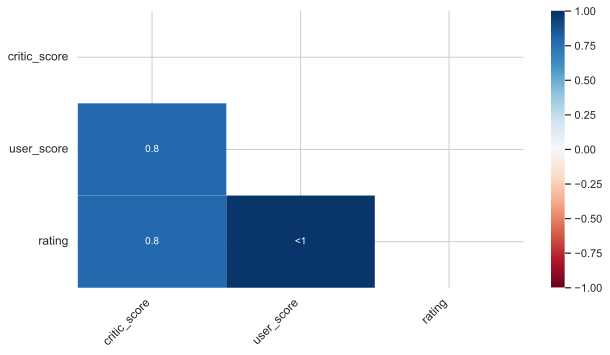

In [34]:
missingno.heatmap(df, figsize=(10,5), fontsize=12);

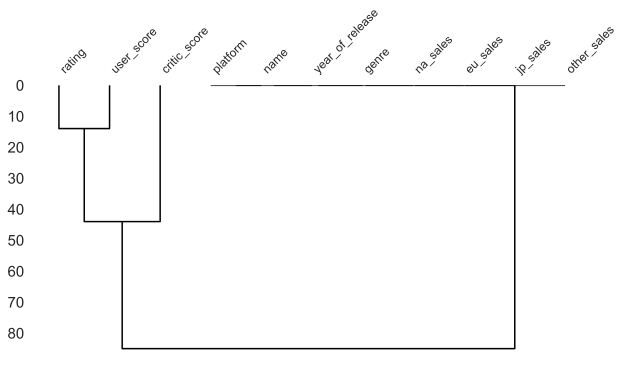

In [35]:
missingno.dendrogram(df, figsize=(10,5), fontsize=12);

Мы видим, что корреляция между столбцами с пропусками очень высокая, а у столбцов `rating` и `user_score` почти прямая корреялция.
А с помощью дендограммы можно увидеть, что в столбце `critic_score` больше всего пропусков и при этом пропуски в `rating` и `user_score` связаны между собой, а уже какие-то пропуски из совокупности `rating` и `user_score` связаны с `critic_score`, также можно увидеть, что значение всех остальных столбцов равно `0`, а значит, как мы уже знаем, пропусков там нет. 

Посмотрим, как поменяется хитмап и дендограмма, после замены `tbd` на `nan` в столбце `user_score`: 

In [36]:
df['user_score'].replace('tbd', np.nan, inplace=True)

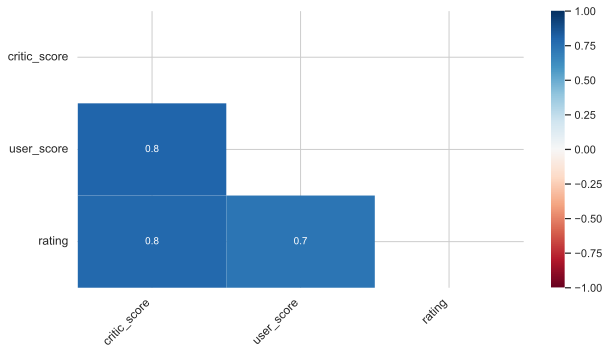

In [37]:
missingno.heatmap(df, figsize=(10,5), fontsize=12);

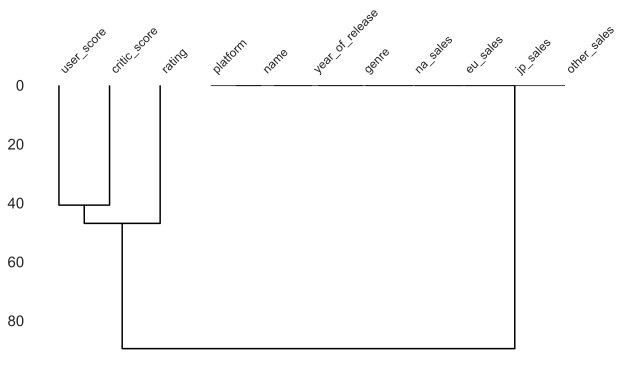

In [38]:
missingno.dendrogram(df, figsize=(10,5), fontsize=12);

Мы видим, что понизилась корреляция пропусков между `rating` и `user_score`, это можно объяснить тем, что, заменив значения `tbd` в столбце `user_score`, то мы добавили "новые" строки в  подсчет пропусков, в которых нет пропусков в столбце `rating`, тем самым, мы можем убеждаться в том, что природа пропусков и значений `tbd` разная. Посмотрим на значение пропусков для строчек, где `user_score` был равен `tbd`, т.е. до изменений:

In [39]:
#этот кусок кода выполняется чуть выше замены `tbd` на `nan`: 
# missingы_from_the_past = pd.concat([df[df['user_score'] == 'tbd'].isna().sum().to_frame().rename(columns = {0:'Количество пропусков'}),
#          round((df[df['user_score'] == 'tbd'].isna().mean().to_frame()*100).rename(columns = {0:'Процент пропусков'}), 2)], axis=1)

missing_from_the_past

,Количество пропусков,Процент пропусков
name,0,0.00
platform,0,0.00
year_of_release,0,0.00
genre,0,0.00
na_sales,0,0.00
eu_sales,0,0.00
jp_sales,0,0.00
other_sales,0,0.00
critic_score,1320,55.56
user_score,0,0.00


И вправду, как мы видим, у строчек, в столбце `user_score` которых  было значение `tbd`, практически нет пропусков в `rating`, но много пропусков в `critic_score`, из-за чего мы можем наблдюдать, что на дендограмме теперь `critic_score` вытестил `rating` и количество пропусков в группе увеличилось

##### Вывод
По итогу, изучив данные в столбцах `critic_score`, `user_score` и `rating` можно признать, что установить природу пропусков в этих данных сложно, однозначно можно сказать, что природа пропусков и значений `tbd` разная, отвечая на вопрос, что делать с пропусками, хочется проговорить, что пропусков очень много, удалять их нельзя, заполнять с помощью медианы или моды беcсмысленно, а придумать хитрую систему, которая будет отталкиваться от каких то параметров - рискованно, так как параметров, влияющих на оценку много. На мой взгляд, наилучший вариант оставить данные на данном этапе в таком виде.

### 2.4* Возвращаемся к преобразованию данных в нужный тип.

In [40]:
df['user_score'] = df['user_score'].astype(float)
df['year_of_release'] = df['year_of_release'].astype(int)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16443 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int32  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float64
 10  rating           9767 non-null   object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.4+ MB


### 2.5 Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.

In [42]:
df['sum_sales'] = df[df.columns[4:8]].sum(axis=1)

In [43]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.00,8.00,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.00,8.30,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.00,8.00,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


## Шаг 3. Проведите исследовательский анализ данных

### 3.1 Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [44]:
df['year_of_release'].value_counts().to_frame().head()

,count
year_of_release,
2008,1427
2009,1426
2010,1255
2007,1197
2011,1136


In [45]:
# обновляем размер
rcParams['figure.figsize'] = 12, 6

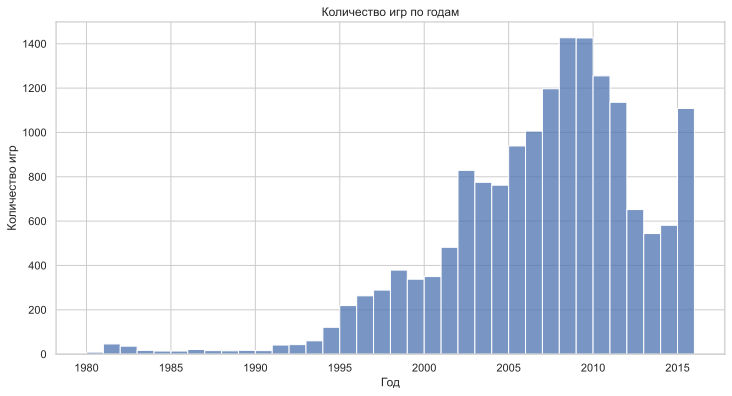

In [46]:
sns.histplot(df, x=df['year_of_release'], bins=36).set(
    title='Количество игр по годам',
    xlabel='Год',
    ylabel='Количество игр');

По графику видно, что рост количества выпущенных игр начался в начале - середине `90ых`, а пик наступил в `2008-2009` годах, после чего наступил спад на несколько лет, и снова виден рост уже в `2016` году. Отвечая на вопрос важны ли данные за вeсь период, то все зависит от условий, если цель совпадает с ТЗ проекта, то для прогноза нужно понимать, что игры долгое время производись исходя из возможностей железа и это могло влиять на жанр, например, вот как менялись доли выпускаемых игр по жанрам на графике снизу. И тут можно заметить, что до 1985года в моде был жанр `action`, а вот ближе 90-м появился какой-то баланс, возможно, потому что жанр, преобладающий в периоде "до" надоел пользователям, а у разработчиков появились возможности к разработке более сложных проектов в других жанрах. Интересно, что в `2000-ых` игры в жанре `action` снова начали выпускать. 





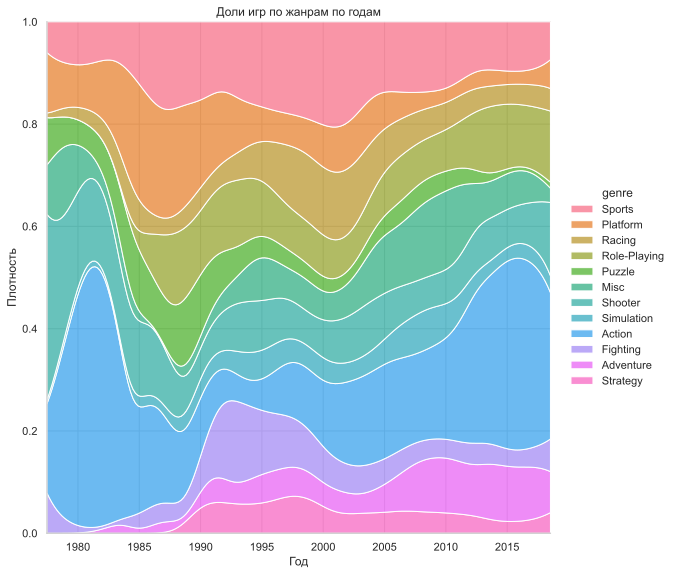

In [47]:
sns.displot(
    data=df ,
    x="year_of_release", hue="genre",
    kind="kde", height=8,
    multiple="fill", clip=(0, None),
    #palette="ch:rot=-1.995,hue=1.25,light=.85"
).set(
    title='Доли игр по жанрам по годам',
    xlabel='Год',
    ylabel='Плотность')
sns.color_palette("husl", 9);

    На отношение выпускаемых игр со стороны разработчиков мы посмотрели, а теперь можно посмотреть на данные с другой стороны, а именно, сколько копий игр и в каких жанрах по годам было куплено:

    Построим табличку, в которой будут записаны прибыли с продаж игр по жанрам и годам

In [48]:
#Построим табличку, в которой будут записаны прибыли с продаж игр по жанрам и годам
sales_by_genre = df.groupby(by=['year_of_release'])['sum_sales'].sum().reset_index()
for i in df['genre'].unique():
    temp = df[df['genre'] == i].groupby(by=['year_of_release'])['sum_sales'].sum().reset_index().rename(columns={'sum_sales': i})
    sales_by_genre = sales_by_genre.merge(temp, how='left')

In [49]:
#что вышло:
sales_by_genre.head()


,year_of_release,sum_sales,Sports,Platform,Racing,Role-Playing,Puzzle,Misc,Shooter,Simulation,Action,Fighting,Adventure,Strategy
0,1980,11.38,0.50,NaN,NaN,NaN,NaN,2.70,7.07,NaN,0.34,0.77,NaN,NaN
1,1981,35.68,0.78,6.92,0.48,NaN,2.25,NaN,10.02,0.44,14.79,NaN,NaN,NaN
2,1982,28.88,1.06,5.03,1.57,NaN,10.04,0.87,3.81,NaN,6.50,NaN,NaN,NaN
3,1983,16.80,3.20,6.93,NaN,NaN,0.78,2.14,0.49,NaN,2.86,NaN,0.40,NaN
4,1984,50.35,6.17,0.69,5.95,NaN,3.14,1.45,31.10,NaN,1.85,NaN,NaN,NaN


In [50]:
#Теперь оставим только жанры, уберем колонку с сумарной прибылью за год в сторону:

sum_sales = sales_by_genre['sum_sales'].copy()
sales_by_genre.drop('sum_sales', axis=1, inplace=True)

#Пропуски данной в таблице это отсутсвие продаж в конкретном жанре, а значит это нулевая прибыль, спокойно поменяем nan на ноль:

sales_by_genre.fillna(0,inplace=True)
sales_by_genre.index = sales_by_genre['year_of_release']

#Индекс сделаем годом
sales_by_genre.drop('year_of_release', axis=1, inplace=True)

In [51]:
sales_by_genre.head()

,Sports,Platform,Racing,Role-Playing,Puzzle,Misc,Shooter,Simulation,Action,Fighting,Adventure,Strategy
year_of_release,,,,,,,,,,,,
1980,0.50,0.00,0.00,0.00,0.00,2.70,7.07,0.00,0.34,0.77,0.00,0.00
1981,0.78,6.92,0.48,0.00,2.25,0.00,10.02,0.44,14.79,0.00,0.00,0.00
1982,1.06,5.03,1.57,0.00,10.04,0.87,3.81,0.00,6.50,0.00,0.00,0.00
1983,3.20,6.93,0.00,0.00,0.78,2.14,0.49,0.00,2.86,0.00,0.40,0.00
1984,6.17,0.69,5.95,0.00,3.14,1.45,31.10,0.00,1.85,0.00,0.00,0.00


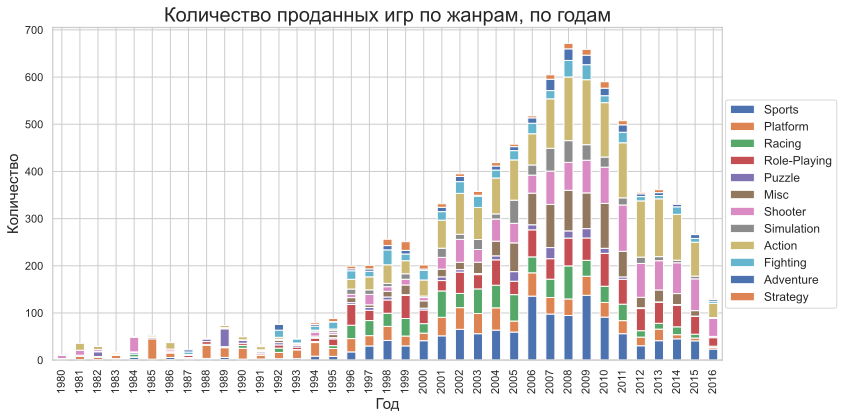

In [52]:
ax = sales_by_genre.plot.bar(stacked=True)
ax.legend(loc='upper right', bbox_to_anchor=(1.18, 0.8), fontsize=12)

plt.title('Количество проданных игр по жанрам, по годам', fontsize=20)
plt.xlabel('Год', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.show();

Прикольно, но тяжело к восприятию, вот так легче будет увидеть в каком году какой жанр лидирует по количеству проданных копий:

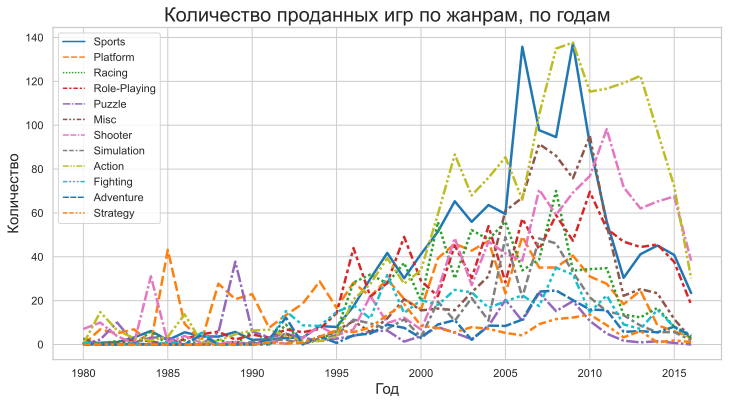

In [53]:
sns.lineplot(data=sales_by_genre, palette="tab10", linewidth=2.5)
plt.title('Количество проданных игр по жанрам, по годам', fontsize=20)
plt.xlabel('Год', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.show();

Можно еще посмотреть на количество проданных копий в разрезе долей по жанрам:

In [54]:
#Разделим продажи по жанрам на продажи за год, чтобы увидеть процентное отношение, продажи за год заранее убрали в переменную `sum_sales`(тут я чет намудрил с табличками, не получалось поделить с годом в индексе,
# поэтому вот):
#индекс в табличку 
sales_by_genre.reset_index(inplace=True)
#делим продажи по жанрам на сумарные продажи за год 
sales_by_genre[sales_by_genre.columns[1:]] = sales_by_genre[sales_by_genre.columns[1:]].div(sum_sales, axis=0)
#и теперь обратно
sales_by_genre.index =  sales_by_genre['year_of_release']
sales_by_genre.drop('year_of_release', axis=1, inplace=True)
sales_by_genre.head()

,Sports,Platform,Racing,Role-Playing,Puzzle,Misc,Shooter,Simulation,Action,Fighting,Adventure,Strategy
year_of_release,,,,,,,,,,,,
1980,0.04,0.00,0.00,0.00,0.00,0.24,0.62,0.00,0.03,0.07,0.00,0.00
1981,0.02,0.19,0.01,0.00,0.06,0.00,0.28,0.01,0.41,0.00,0.00,0.00
1982,0.04,0.17,0.05,0.00,0.35,0.03,0.13,0.00,0.23,0.00,0.00,0.00
1983,0.19,0.41,0.00,0.00,0.05,0.13,0.03,0.00,0.17,0.00,0.02,0.00
1984,0.12,0.01,0.12,0.00,0.06,0.03,0.62,0.00,0.04,0.00,0.00,0.00


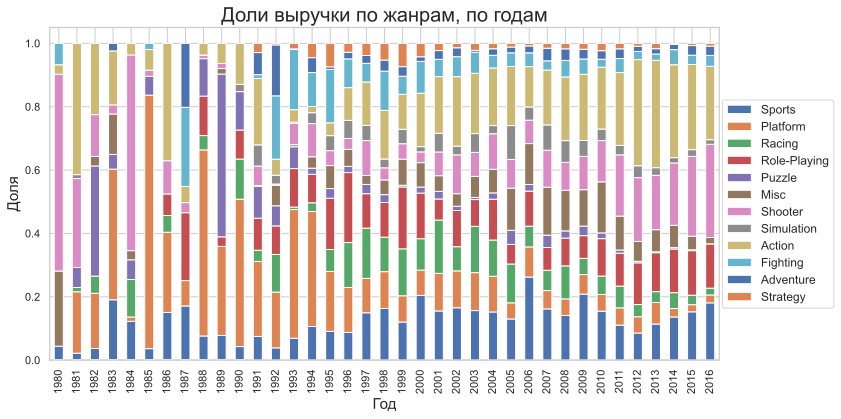

In [55]:
#Строим барплот по годам и долям жанров
ax = sales_by_genre.plot.bar(stacked=True)
ax.legend(loc='upper right', bbox_to_anchor=(1.18, 0.8), fontsize=12)

plt.title('Доли выручки по жанрам, по годам', fontsize=20)
plt.xlabel('Год', fontsize=15)
plt.ylabel('Доля', fontsize=15)
plt.show();

#### Вывод
По итогу, наверное, можно сказать, что для выявления факторов, влияющих на успешность игры, можно смело сказать, что какая-то часть старых данных уже является не актуальной, но, если говорить про жизненный цикл и популярность жанров, то, мне кажется, и старые данные могут быть полезны

### 3.2 Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [56]:
sum_sales_by_platform = df.groupby('platform')['sum_sales'].sum().to_frame().sort_values(by='sum_sales',ascending=False)
sum_sales_by_platform.head()

,sum_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.33
Wii,891.18
DS,802.78


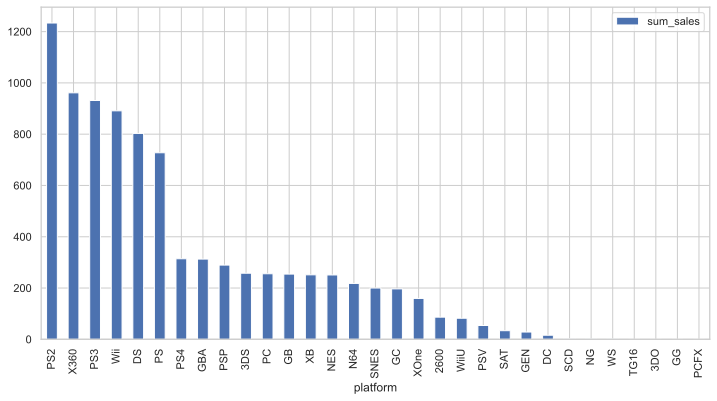

In [57]:
sum_sales_by_platform.plot.bar();

In [58]:
#За платформы с наибольшими продажами возьмем топ-6 платформ
top_platform_list = sum_sales_by_platform.head(6)
top_platform_list.index.tolist()
pd.pivot_table(df[df['platform'].isin(top_platform_list.index.tolist()) == True], columns='platform', values='sum_sales', index='year_of_release', aggfunc='sum')


platform,DS,PS,PS2,PS3,Wii,X360
year_of_release,,,,,,
1985,0.02,NaN,NaN,NaN,NaN,NaN
1994,NaN,6.03,NaN,NaN,NaN,NaN
1995,NaN,35.96,NaN,NaN,NaN,NaN
1996,NaN,94.70,NaN,NaN,NaN,NaN
1997,NaN,136.17,NaN,NaN,NaN,NaN
1998,NaN,169.49,NaN,NaN,NaN,NaN
1999,NaN,144.53,NaN,NaN,NaN,NaN
2000,NaN,96.37,39.17,NaN,NaN,NaN
2001,NaN,35.59,166.43,NaN,NaN,NaN


По таблице видно, что на платформе в данных есть продажа в 1985году, посмотрим, что это:

In [59]:
df[(df['platform']=='DS') & (df['year_of_release'] == 1985)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.00,0.00,0.02,0.00,NaN,NaN,NaN,0.02


In [60]:
df[df['name'] == 'Strongest Tokyo University Shogi DS']
# Я прогуглил, игра от `2007` года, поменяем год и обновим таблицу: 
df[df['name'] == 'Strongest Tokyo University Shogi DS'] = df[df['name'] == 'Strongest Tokyo University Shogi DS'].replace(1985, 2007)

In [61]:
#теперь ок
temp = pd.pivot_table(df[df['platform'].isin(top_platform_list.index.tolist()) == True], columns='platform', values='sum_sales', index='year_of_release', aggfunc='sum')
temp

platform,DS,PS,PS2,PS3,Wii,X360
year_of_release,,,,,,
1994,NaN,6.03,NaN,NaN,NaN,NaN
1995,NaN,35.96,NaN,NaN,NaN,NaN
1996,NaN,94.70,NaN,NaN,NaN,NaN
1997,NaN,136.17,NaN,NaN,NaN,NaN
1998,NaN,169.49,NaN,NaN,NaN,NaN
1999,NaN,144.53,NaN,NaN,NaN,NaN
2000,NaN,96.37,39.17,NaN,NaN,NaN
2001,NaN,35.59,166.43,NaN,NaN,NaN
2002,NaN,6.67,205.38,NaN,NaN,NaN


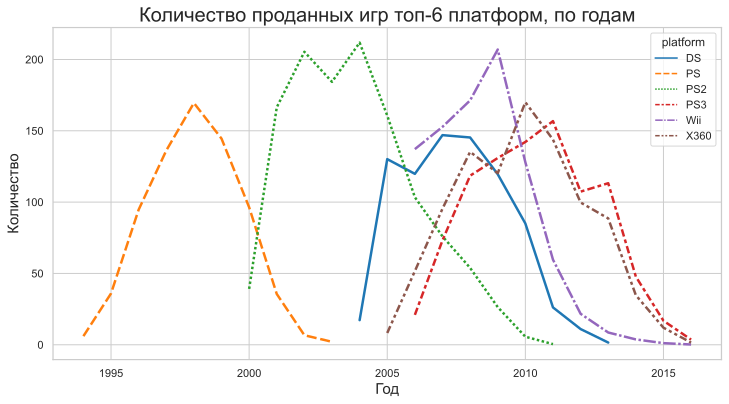

In [62]:
sns.lineplot(data=temp, palette="tab10", linewidth=2.5)
plt.title('Количество проданных игр топ-6 платформ, по годам', fontsize=20)
plt.xlabel('Год', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.show();

In [63]:
temp = df[df['platform'].isin(top_platform_list.index.tolist()) == True].groupby('platform')['year_of_release'].unique().to_frame().reset_index()
temp['lifetime'] = temp.apply(lambda row: len(row['year_of_release']), axis=1)
temp.index = temp['platform']
temp

,platform,year_of_release,lifetime
platform,,,
DS,DS,"[2006, 2005, 2010, 2009, 2004, 2007, 2012, 2008, 2011, 2013]",10
PS,PS,"[1997, 1999, 1998, 1996, 2000, 1995, 2001, 2002, 1994, 2003]",10
PS2,PS2,"[2004, 2002, 2001, 2003, 2006, 2007, 2005, 2000, 2008, 2009, 2010, 2011]",12
PS3,PS3,"[2013, 2012, 2011, 2010, 2009, 2008, 2007, 2014, 2006, 2015, 2016]",11
Wii,Wii,"[2006, 2008, 2009, 2007, 2011, 2010, 2012, 2013, 2014, 2015, 2016]",11
X360,X360,"[2010, 2013, 2011, 2012, 2009, 2007, 2008, 2006, 2014, 2005, 2015, 2016]",12


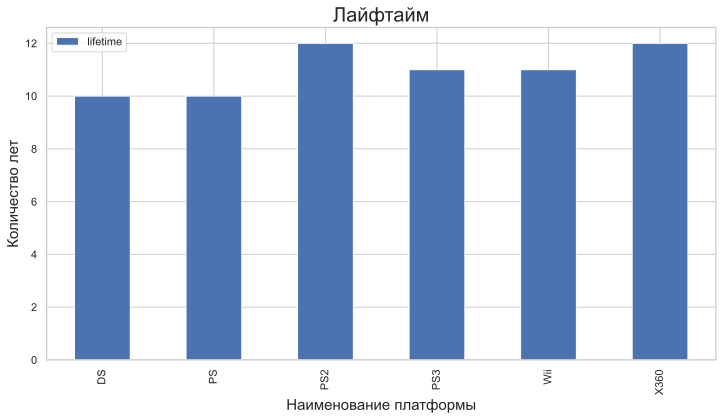

In [64]:
temp.plot.bar();
plt.title('Лайфтайм', fontsize=20)
plt.xlabel('Наименование платформы', fontsize=15)
plt.ylabel('Количество лет', fontsize=15)
plt.show();

In [65]:
temp['lifetime'].mean()

11.0

In [66]:
# А какой лайфтайм будет по всему датафрейму? 
temp = df.groupby('platform')['year_of_release'].unique().to_frame().reset_index()
temp['lifetime'] = temp.apply(lambda row: len(row['year_of_release']), axis=1)
temp.index = temp['platform']


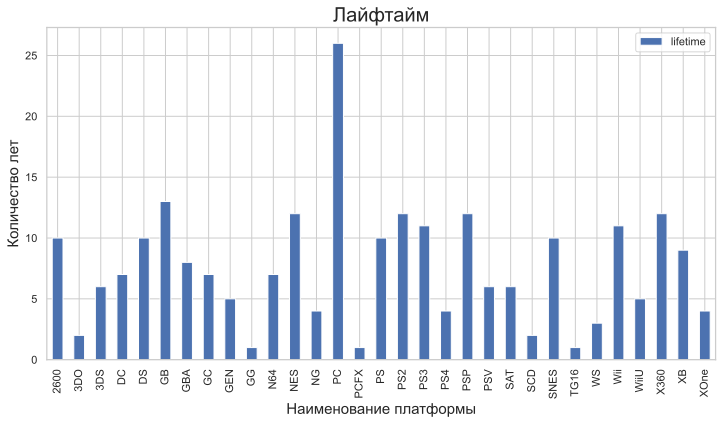

In [67]:
temp.plot.bar();
plt.title('Лайфтайм', fontsize=20)
plt.xlabel('Наименование платформы', fontsize=15)
plt.ylabel('Количество лет', fontsize=15)
plt.show();

In [68]:
temp['lifetime'].mean()

7.645161290322581

#### Вывод
Самые успешные платформы живут, в среднем, 11 лет, а средний срок жизни платформы по всему датафрейму - почти 7,5 лет. При этом, на графике видно, что игры на платформы от одного производителя продаются в "нахлест", хорошо видно на примере приставок `PS`, `PS2`, `PS3`, что объясняется релизом новой приставки и переходом аудитории с одной платформы на другую, а вот производители платформ конкурентов не стесняются релизиться на рынок, в условиях высокой конкуренции.

### 3.3 Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.

Отталкиваясь от графика лайфтайма успешных платформ хочется назначить период минимум в 5 лет, но, есть ощущение, что у топовых платформ лайфтайм подходит к концу, поэтому, стоит посмотреть на график со стороны 2016 года:

In [69]:
temp = pd.pivot_table(df[df['year_of_release'] >=2013], columns='platform', values='sum_sales', index='year_of_release', aggfunc='sum')


In [70]:
temp

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


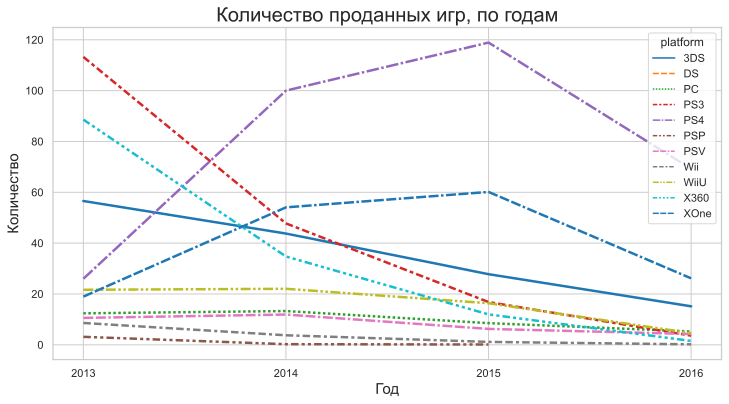

In [71]:
sns.lineplot(data=temp, palette="tab10", linewidth=2.5)
plt.title('Количество проданных игр, по годам', fontsize=20)
plt.xlabel('Год', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.xticks([2013, 2014, 2015, 2016])
plt.show();

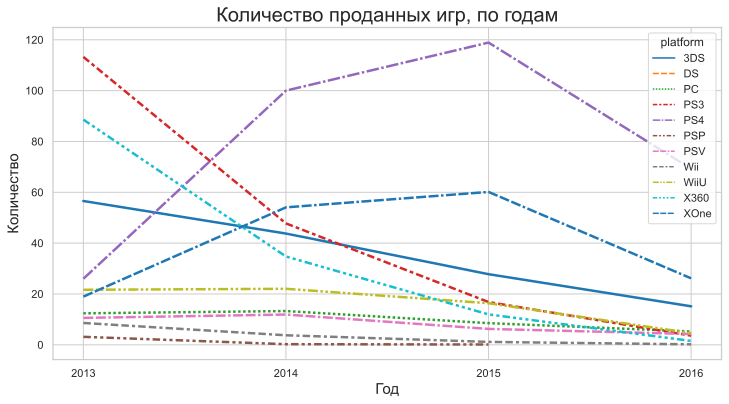

In [72]:
sns.lineplot(data=temp, palette="tab10", linewidth=2.5, )
plt.title('Количество проданных игр, по годам', fontsize=20)
plt.xlabel('Год', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.xticks([2013, 2014, 2015, 2016])
plt.show();

#### Вывод
Исходя из графика сверху, я бы установил актуальный период в срок 3 года, как раз видно, что у текущих лидеров продажи превысили продажи бывших лидеров, а именно `PS4` обогнал `PS3`, а `XOne` обогнал`X360`, а это значит, что данные по бывшим лидерам не будут мешать при дальнейшем анализе

### 3.4 Не учитывайте в работе данные за предыдущие годы.

In [73]:
current_df = df.copy()
current_df = current_df[current_df['year_of_release'] >= 2014]
current_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1689 entries, 31 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1689 non-null   object 
 1   platform         1689 non-null   object 
 2   year_of_release  1689 non-null   int32  
 3   genre            1689 non-null   object 
 4   na_sales         1689 non-null   float64
 5   eu_sales         1689 non-null   float64
 6   jp_sales         1689 non-null   float64
 7   other_sales      1689 non-null   float64
 8   critic_score     718 non-null    float64
 9   user_score       888 non-null    float64
 10  rating           940 non-null    object 
 11  sum_sales        1689 non-null   float64
dtypes: float64(7), int32(1), object(4)
memory usage: 164.9+ KB


### 3.5 Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

In [74]:
temp = pd.pivot_table(current_df, columns='platform', values='sum_sales', index='year_of_release', aggfunc='sum')

In [75]:
temp

platform,3DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,
2014,43.76,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


In [76]:
temp.index

Index([2014, 2015, 2016], dtype='int32', name='year_of_release')

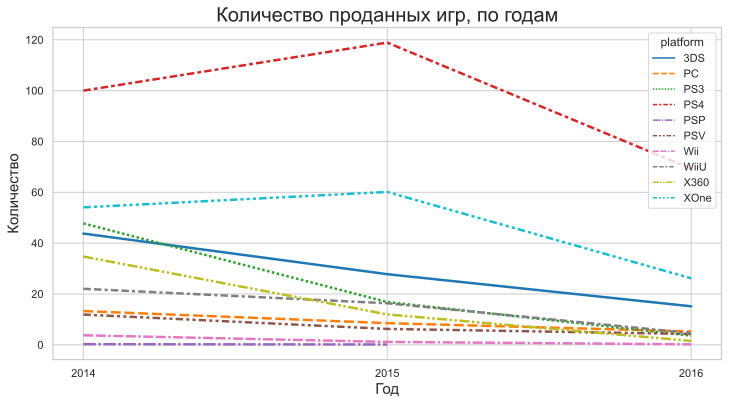

In [77]:
sns.lineplot(data=temp, palette="tab10", linewidth=2.5)
plt.title('Количество проданных игр, по годам', fontsize=20)
plt.xlabel('Год', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.xticks([2014, 2015, 2016])
plt.show();

#### Вывод
Потенциально прибыльные платформы - `PS4`, `XOne`. У всех остальные платформ наблюдается спад.

### 3.6 Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

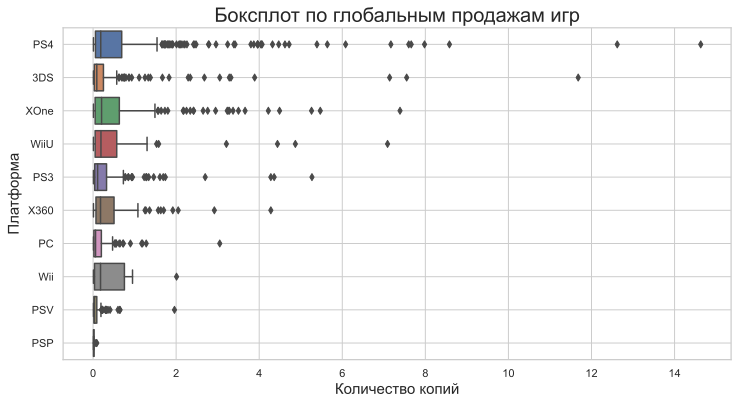

In [80]:
sns.boxplot(x="sum_sales", y="platform", data=current_df)
plt.grid(True)
plt.title('Боксплот по глобальным продажам игр', fontsize=20)
plt.xlabel('Количество копий', fontsize=15)
plt.ylabel('Платформа', fontsize=15)
plt.show();

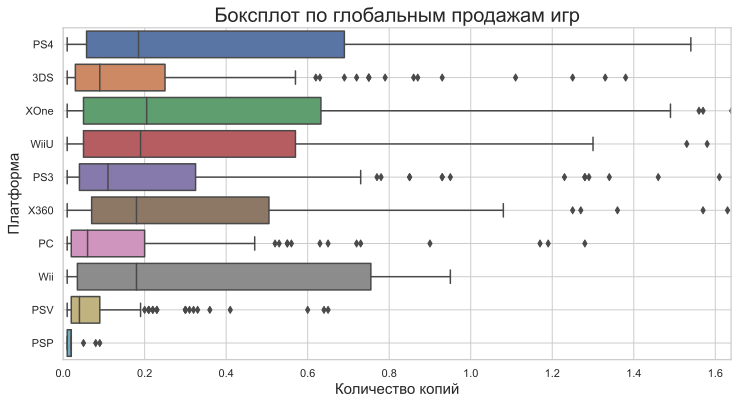

In [81]:
ps4 = current_df[current_df['platform'] == 'PS4']['sum_sales']
sns.boxplot(x="sum_sales", y="platform", data=current_df)
plt.xlim(0, (ps4.quantile(0.75) - ps4.quantile(0.25))*1.5 + ps4.quantile(0.75))
plt.grid(True)
plt.title('Боксплот по глобальным продажам игр', fontsize=20)
plt.xlabel('Количество копий', fontsize=15)
plt.ylabel('Платформа', fontsize=15)
plt.show();

In [82]:
current_df.groupby('platform')['sum_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,212.00,0.41,1.19,0.01,0.03,0.09,0.25,11.68
PC,151.00,0.18,0.33,0.01,0.02,0.06,0.20,3.05
PS3,219.00,0.31,0.63,0.01,0.04,0.11,0.33,5.27
PS4,376.00,0.77,1.61,0.01,0.06,0.18,0.69,14.63
PSP,13.00,0.03,0.03,0.01,0.01,0.02,0.02,0.09
PSV,295.00,0.08,0.14,0.01,0.02,0.04,0.09,1.96
Wii,11.00,0.46,0.63,0.01,0.04,0.18,0.76,2.01
WiiU,73.00,0.59,1.16,0.01,0.05,0.19,0.57,7.09
X360,111.00,0.43,0.63,0.01,0.07,0.18,0.51,4.28


#### Вывод


Анализируя платформы по бокcплоту можно заметить, что: 
* у `PS4` много проектов, с большим количеством проданных копий, но при этом медиана меньше чем у главного конкурента `XOne`, но при этом у `PS4` правая граница дальше, чем у `XOne`, что должно говорить о том, что среднее значение будет больше у `PS4`
* У многих платформ есть проекты, количество продаж которых, выходит за пределы 95 квантиля, на мой взгляд, это нельзя считать выбросами, потому что речь идет о самых успешных платформах в данный отрезок времени, а также, возможно, о самых продаваемых проектах

* Средние значения по продажам самые высокие у `PS4` - `0.77` и у `XOne` - `0.62`
* Стали видны максимальные значения по продажам, `PS4` - `14.63` и у `3DS` - `11.68`
* У `Wii` самый широкий квартильный размах, что может говорить и широком диапазоне показателей продаж
* Большие верхние границы у платформ `PS4`, `XOne`, `WiiU` говорит о наличии проектов с большим кол-вом продаж на этих платформах

На мой взгляд нет смысла описывать остальные платформы, потому что части из них заканчивается жизненный цикл, а график по количеству проданных игр по годам доказывает, что они не очень привлекательные. 


### 3.7 Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

In [83]:
current_df_for_corr = current_df.copy()
current_df_for_corr.dropna(subset=['critic_score', 'user_score'], inplace=True)
print('Корреляция между оценками критиков и продажами:', round(current_df_for_corr[current_df_for_corr['platform'] == 'PS4']['sum_sales'].corr(current_df_for_corr['critic_score']), 5))
print('Корреляция между оценками пользователей и продажами:', round(current_df_for_corr[current_df_for_corr['platform'] == 'PS4']['sum_sales'].corr(current_df_for_corr['user_score']), 5))

Корреляция между оценками критиков и продажами: 0.4019
Корреляция между оценками пользователей и продажами: -0.04319


In [84]:
current_df_for_corr[current_df_for_corr['platform'] == 'PS4'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 234 entries, 42 to 16530
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             234 non-null    object 
 1   platform         234 non-null    object 
 2   year_of_release  234 non-null    int32  
 3   genre            234 non-null    object 
 4   na_sales         234 non-null    float64
 5   eu_sales         234 non-null    float64
 6   jp_sales         234 non-null    float64
 7   other_sales      234 non-null    float64
 8   critic_score     234 non-null    float64
 9   user_score       234 non-null    float64
 10  rating           224 non-null    object 
 11  sum_sales        234 non-null    float64
dtypes: float64(7), int32(1), object(4)
memory usage: 22.9+ KB


In [85]:

print('Корреляция между оценками критиков и продажами:', round(current_df[current_df['platform'] == 'PS4']['sum_sales'].corr(current_df['critic_score']), 5))
print('Корреляция между оценками пользователей и продажами:', round(current_df[current_df['platform'] == 'PS4']['sum_sales'].corr(current_df['user_score']), 5))

Корреляция между оценками критиков и продажами: 0.40266
Корреляция между оценками пользователей и продажами: -0.04013


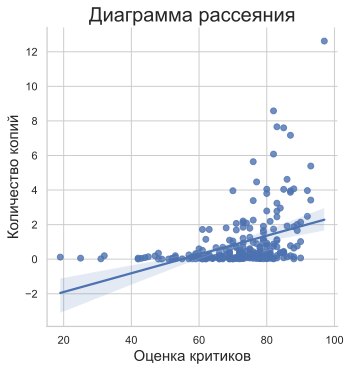

In [86]:
sns.lmplot(data=current_df_for_corr[current_df_for_corr['platform'] == 'PS4'], x="critic_score", y="sum_sales")
plt.grid(True)
plt.title('Диаграмма рассеяния', fontsize=20)
plt.ylabel('Количество копий', fontsize=15)
plt.xlabel('Оценка критиков', fontsize=15)
plt.show(); 

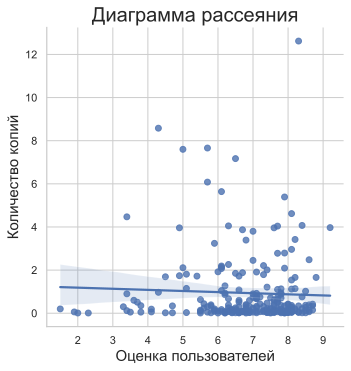

In [87]:
sns.lmplot(data=current_df_for_corr[current_df_for_corr['platform'] == 'PS4'], x="user_score", y="sum_sales")
plt.grid(True)
plt.title('Диаграмма рассеяния', fontsize=20)
plt.ylabel('Количество копий', fontsize=15)
plt.xlabel('Оценка пользователей', fontsize=15)
plt.show();

#### Вывод
Посчитав корреляцию Пирсона и построив диаграммы рассеяния для плотформы `PS4`, с уверенностью можно сказать, что: 

* Корреляции между оценками критиков и продажами прямая, слабая
* Корреляция между оценками пользователей и продажами - отсутствует

### 3.8 Соотнесите выводы с продажами игр на других платформах.
Давайте посмотрим на корреляцию оценок критиков и продаж и на корреляцию оценок пользователей и продаж по всем платформам 

In [88]:
# создадим списки для будушего датафрейма
platform_list = current_df_for_corr['platform'].unique().tolist()
corr_critic_list = []
corr_user_list = []

# циклом запишем корреляции и установим минимальное кол-во наблюдний, равное 5
for platform in platform_list:
    corr_critic_list.append(round(current_df_for_corr[current_df_for_corr['platform'] == platform]['sum_sales'].corr(current_df_for_corr['critic_score'], min_periods=5), 2))
    corr_user_list.append(round(current_df_for_corr[current_df_for_corr['platform'] == platform]['sum_sales'].corr(current_df_for_corr['user_score'], min_periods=5), 2))



platform_corr = pd.DataFrame({'platform':platform_list,
                              'corr_critic':corr_critic_list,
                              'corr_user':corr_user_list})

platform_corr

,platform,corr_critic,corr_user
0,PS4,0.40,-0.04
1,WiiU,0.38,0.41
2,XOne,0.42,-0.09
3,3DS,0.28,0.28
4,PC,0.17,-0.09
5,X360,0.53,0.34
6,PS3,0.45,0.16
7,PSV,0.04,0.02


#### Вывод
Посчитав корреляцию Пирсона и построив диаграммы рассеяния для всех платформ, сможно сказать, что: 

* Корреляции между оценками критиков и продажами либо отсутствует, либо прямая, слабая, варьируется в значениях  (0.04; 0.53)
* Корреляция между оценками пользователей и продажами - аналогично корреляции между оценками критики и продажами. Либо отсутствует, либо прямая, слабая, варьируется в значениях  (-0.09; 0.41)

Стоит отметить, что в датафрейме есть платформы, у которых наблюдается прямая, слабая связь и между оценками критиков и продажами, и между оценками пользователей и продажами - `X360`, `3DS`, `WiiU`, а таткже у некоторых платформ наблюдается отсутствие связи и между оценками кркитиков и продажами, и между оценками пользователей и продажами - `PSV`, `PC`


### 3.9 Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

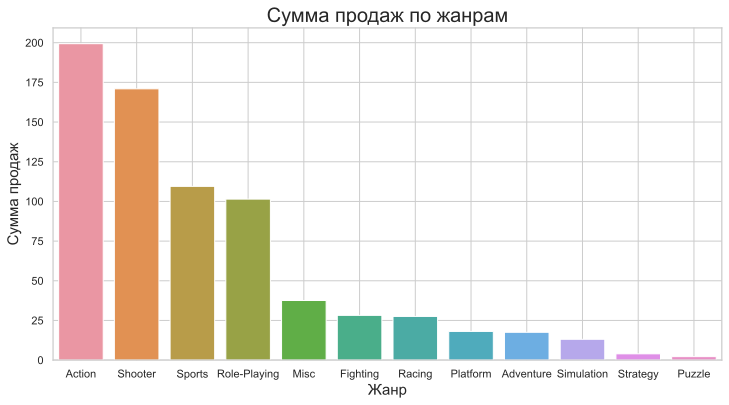

In [89]:
sales_by_genre = pd.pivot_table(data=current_df, index='genre', values='sum_sales', aggfunc='sum').sort_values(by='sum_sales', ascending=False).reset_index()
sns.barplot(data=sales_by_genre, x='genre', y="sum_sales")
plt.grid(True)
plt.title('Сумма продаж по жанрам', fontsize=20)
plt.ylabel('Сумма продаж', fontsize=15)
plt.xlabel('Жанр', fontsize=15)
plt.show();

In [90]:
sales_by_genre

,genre,sum_sales
0,Action,199.36
1,Shooter,170.94
2,Sports,109.48
3,Role-Playing,101.44
4,Misc,37.55
5,Fighting,28.22
6,Racing,27.52
7,Platform,18.09
8,Adventure,17.55
9,Simulation,13.13


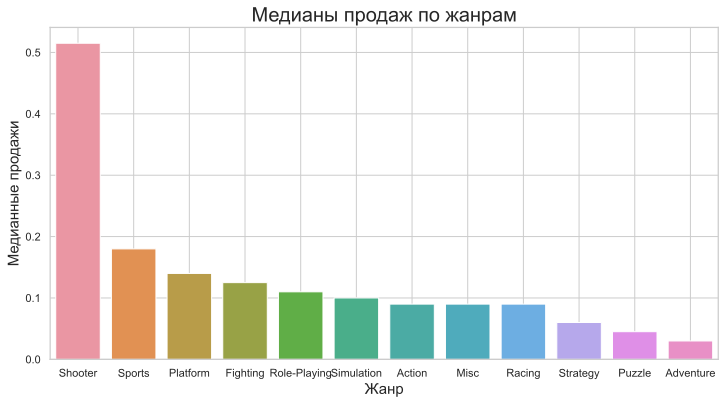

In [91]:
median_by_genre = pd.pivot_table(data=current_df, index='genre', values='sum_sales', aggfunc='median').sort_values(by='sum_sales', ascending=False).reset_index()
sns.barplot(data=median_by_genre, x='genre', y="sum_sales")
plt.grid(True)
plt.title('Медианы продаж по жанрам', fontsize=20)
plt.ylabel('Медианные продажи', fontsize=15)
plt.xlabel('Жанр', fontsize=15)
plt.show();

In [92]:
median_by_genre

,genre,sum_sales
0,Shooter,0.52
1,Sports,0.18
2,Platform,0.14
3,Fighting,0.12
4,Role-Playing,0.11
5,Simulation,0.10
6,Action,0.09
7,Misc,0.09
8,Racing,0.09
9,Strategy,0.06


#### Вывод
Самые большие суммарные продажи, в период с `2014` по `2016` гг являются `action`, `shoter`, `sports`, `role-playing`. 
Если попытаться проанализировать сами жанры, то такое распределение наводит на мысль о моде, топ-3 жанра в распределении, на мой взгляд сильно отличается от топ-3 конца распределения. Симуляторы, стратегии и пазлы медленные, размеренные и возможно, даже, долгие игры,  когда топ-3 лидера в жанре, как правило, сессионные игры, с быстрым и насыщенным геймплеем. Если мои доводы верны, то данный особенность говорит о том, что в 2014-2016 гг у пользователей, явно, был спрос динамичные игры

***Наиболее часто продающиеся жанры, в период с `2014` по `2016` гг являются `shooter`, `sports`, `platform`, `fighting`. 
А вот если смотреть на продажи по медиане в жанре, то жанр `Shooter` лидирует с большиим отрывом, а топ-3 закрывают `Sports` и `Plarform`. Игры с самым маленьким медианным значением - `Strategy`, `Puzzle`, `Adveenturee`, почти как и с  топ сумарных продаж***

## Шаг 4. Составьте портрет пользователя каждого региона

Определите для пользователя каждого региона (NA, EU, JP):
* Самые популярные платформы (топ-5). Опишите различия в долях продаж.
* Самые популярные жанры (топ-5). Поясните разницу.
* Влияет ли рейтинг ESRB на продажи в отдельном регионе?

### 4.1 Самые популярные платформы (топ-5). Опишите различия в долях продаж.

In [93]:
#функция чтобы бахнуть строку с остальными платформами и поделить все на сумму продаж
def region(region, platform_or_genre):
    top = current_df.groupby(platform_or_genre)[region].sum()
    top = top.sort_values(ascending = False).to_frame()
    temp = top[region][5:].sum()
    top = top.head()
    top = top.T
    top['other'] = temp
    top = top.div(top.sum(axis=1), axis=0)
    return top

In [94]:
#и в отдельные строчки и в датафрей 
na_top = region('na_sales', 'platform')
eu_top = region('eu_sales', 'platform')
jp_top = region('jp_sales', 'platform')
top_region = pd.concat([na_top,eu_top,jp_top])
top_region

platform,PS4,XOne,X360,3DS,PS3,other,PC,PSV,WiiU
na_sales,0.35,0.29,0.10,0.08,0.08,0.11,NaN,NaN,NaN
eu_sales,0.48,0.17,NaN,0.06,0.09,0.13,0.07,NaN,NaN
jp_sales,0.16,NaN,NaN,0.48,0.12,0.01,NaN,0.16,0.08


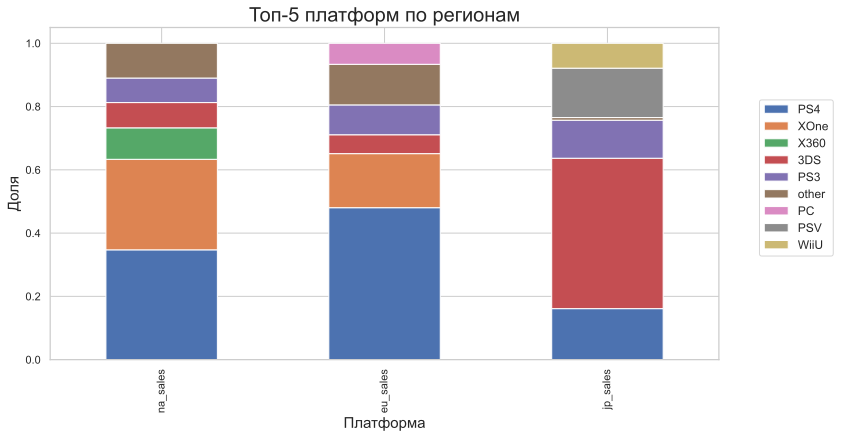

In [95]:
#Строим барплот стаком из датафрейма без процентов не красиво(
ax = top_region.plot.bar(stacked=True)
ax.legend(loc='upper right', bbox_to_anchor=(1.18, 0.8), fontsize=12)
plt.title('Топ-5 платформ по регионам', fontsize=20)
plt.xlabel('Платформа', fontsize=15)
plt.ylabel('Доля', fontsize=15)
plt.show();

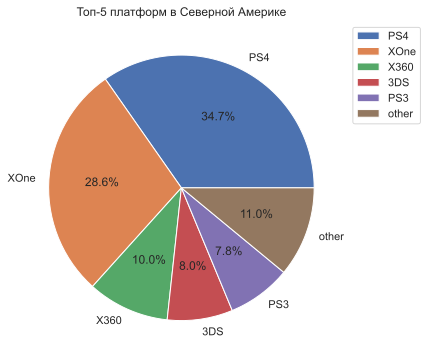

In [96]:
# отдельно круговые, красиво
plt.figure(figsize=(10,6))
plt.pie(na_top.T['na_sales'], labels = na_top.T.index, 
        autopct='%1.1f%%')
plt.title("Топ-5 платформ в Северной Америке", fontsize=12)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()



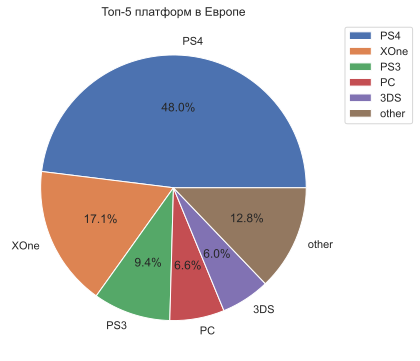

In [97]:
plt.figure(figsize=(10,6))
plt.pie(eu_top.T['eu_sales'], labels = eu_top.T.index, 
        autopct='%1.1f%%')
plt.title("Топ-5 платформ в Европе", fontsize=12)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()


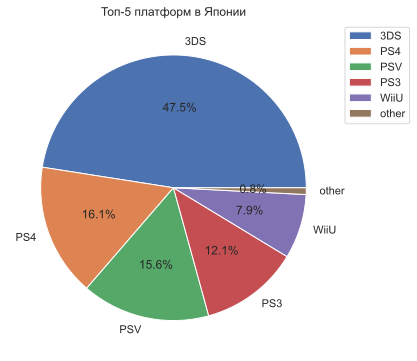

In [98]:
plt.figure(figsize=(10,6))
plt.pie(jp_top.T['jp_sales'], labels = jp_top.T.index, 
        autopct='%1.1f%%')
plt.title("Топ-5 платформ в Японии", fontsize=12)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

#### Вывод

Три региона получились очень разными, причем Северная Америка и Европа еще похожа своими топ-2 платформами(`PS4` и `XOne`), что вполне ожидаемо, они крутые и новые на данный промежуток времени, а вот регион Японии совсем удивил. Нинтендо впереди планеты всей, ну, японцы шарят в японских приставках) Думаю, стоит обратить внимание, что выходить на Японский рынок с игрой под платформу не из Японии - самоубийство. 

### 4.2 Самые популярные жанры (топ-5). Поясните разницу.

In [99]:
#и в отдельные строчки и в датафрей 
na_top = region('na_sales', 'genre')
eu_top = region('eu_sales', 'genre')
jp_top = region('jp_sales', 'genre')
top_region = pd.concat([na_top,eu_top,jp_top])
top_region

genre,Shooter,Action,Sports,Role-Playing,Misc,other,Racing,Fighting
na_sales,0.28,0.26,0.16,0.12,0.05,0.13,NaN,NaN
eu_sales,0.24,0.28,0.17,0.10,NaN,0.16,0.05,NaN
jp_sales,0.05,0.32,NaN,0.33,0.06,0.17,NaN,0.07


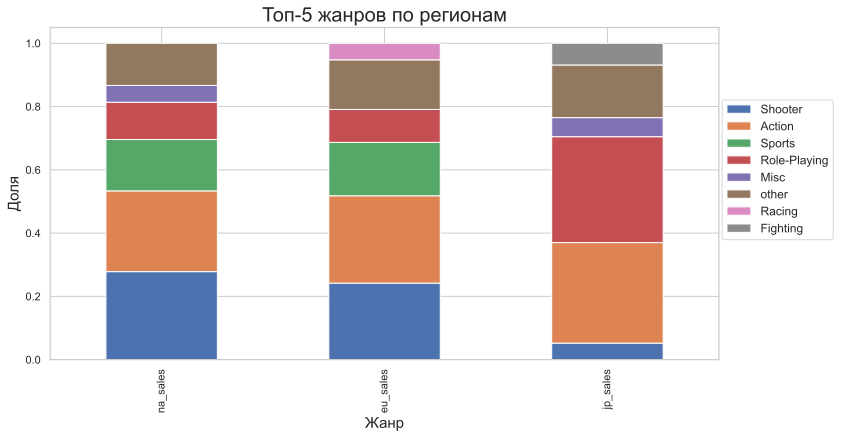

In [100]:
#Строим барплот стаком из датафрейма без процентов не красиво(
ax = top_region.plot.bar(stacked=True)
ax.legend(loc='upper right', bbox_to_anchor=(1.18, 0.8), fontsize=12)
plt.title('Топ-5 жанров по регионам', fontsize=20)
plt.xlabel('Жанр', fontsize=15)
plt.ylabel('Доля', fontsize=15)
plt.show();

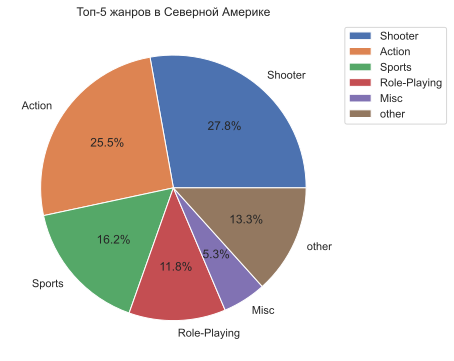

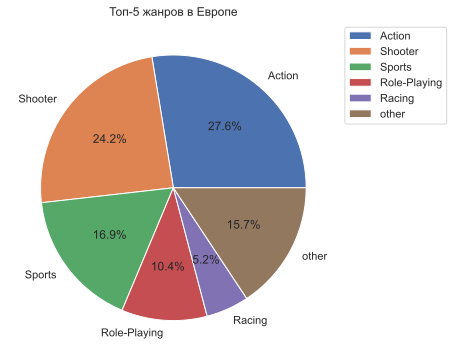

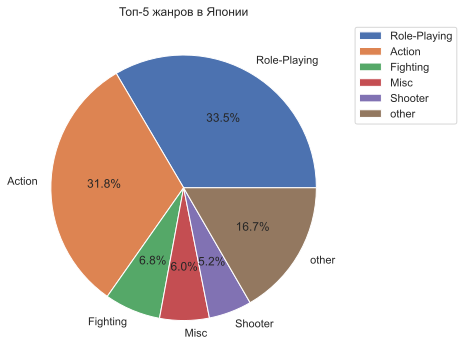

In [101]:
# отдельно круговые, красиво
plt.figure(figsize=(10,6))
plt.pie(na_top.T['na_sales'], labels = na_top.T.index, 
        autopct='%1.1f%%')
plt.title("Топ-5 жанров в Северной Америке", fontsize=12)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

plt.figure(figsize=(10,6))
plt.pie(eu_top.T['eu_sales'], labels = eu_top.T.index, 
        autopct='%1.1f%%')
plt.title("Топ-5 жанров в Европе", fontsize=12)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

plt.figure(figsize=(10,6))
plt.pie(jp_top.T['jp_sales'], labels = jp_top.T.index, 
        autopct='%1.1f%%')
plt.title("Топ-5 жанров в Японии", fontsize=12)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

#### Вывод
Опять Северная Америка и Европа очень похожи, хоть и первые и вторые места перетасованы, а глобальное различие только в топ-5 жанре, в Европе это `Racing`, a в Северной Америке `Misc`. В Японии опять все по своему, на первом месте `Role-Playing`, не удивлюсь, что именно на Японию приходится львиная доля от продаж в этом жанре. 


### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [102]:
current_df['rating'] = current_df['rating'].fillna('unknown')
#и в отдельные строчки и в датафрей 

na_top = region('na_sales', 'rating')
na_top.drop(columns=na_top.columns[-1], axis= 1 , inplace= True )
eu_top = region('eu_sales', 'rating')
eu_top.drop(columns=eu_top.columns[-1], axis= 1 , inplace= True )
jp_top = region('jp_sales', 'rating')
jp_top.drop(columns=jp_top.columns[-1], axis= 1 , inplace= True )
top_region = pd.concat([na_top,eu_top,jp_top])
#top_region.drop(top_region.columns[-1], axis=1, inplace=True)
top_region

rating,M,unknown,E,T,E10+
na_sales,0.34,0.23,0.18,0.14,0.12
eu_sales,0.35,0.22,0.21,0.13,0.10
jp_sales,0.09,0.61,0.10,0.16,0.05


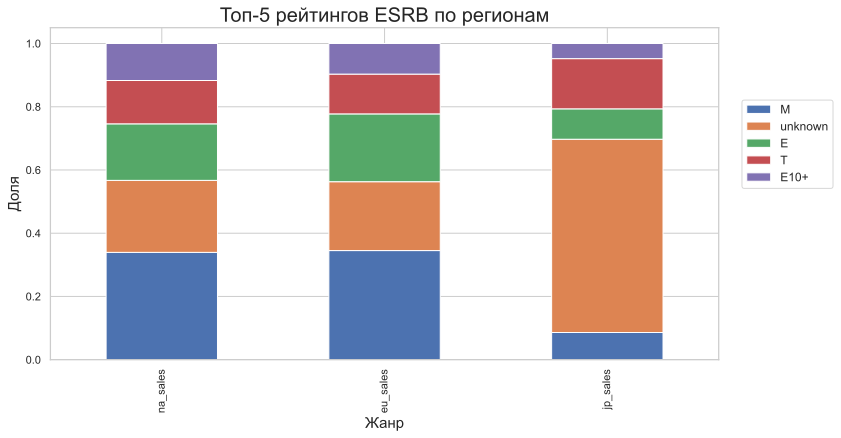

In [103]:
#Строим барплот стаком из датафрейма без процентов не красиво(
ax = top_region.plot.bar(stacked=True)
ax.legend(loc='upper right', bbox_to_anchor=(1.18, 0.8), fontsize=12)
plt.title('Топ-5 рейтингов ESRB по регионам', fontsize=20)
plt.xlabel('Жанр', fontsize=15 )
plt.ylabel('Доля', fontsize=15)
plt.show();

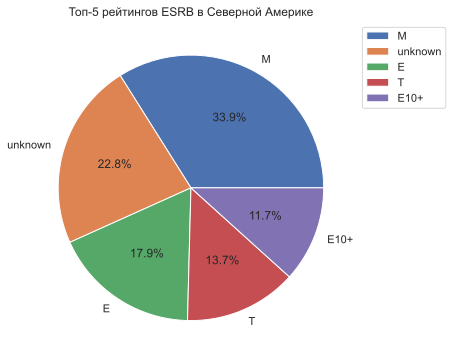

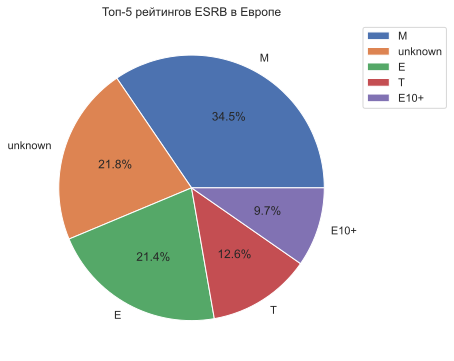

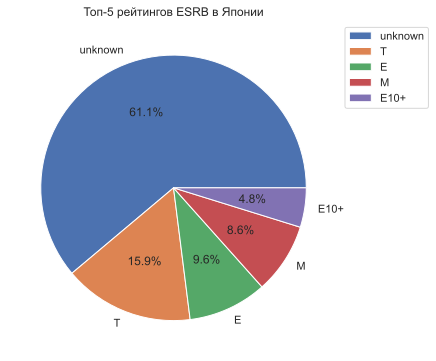

In [104]:
# отдельно круговые, красиво
plt.figure(figsize=(10,6))
plt.pie(na_top.T['na_sales'], labels = na_top.T.index, 
        autopct='%1.1f%%')
plt.title("Топ-5 рейтингов ESRB в Северной Америке", fontsize=12)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

plt.figure(figsize=(10,6))
plt.pie(eu_top.T['eu_sales'], labels = eu_top.T.index, 
        autopct='%1.1f%%')
plt.title("Топ-5 рейтингов ESRB в Европе", fontsize=12)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

plt.figure(figsize=(10,6))
plt.pie(jp_top.T['jp_sales'], labels = jp_top.T.index, 
        autopct='%1.1f%%')
plt.title("Топ-5 рейтингов ESRB в Японии", fontsize=12)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [105]:
def sepcial_region(region, platform_or_genre):
    top = current_df.groupby(platform_or_genre)[region].sum()
    top = top.sort_values(ascending = False).to_frame()
    top = top.head()
    top = top.T
    return top

In [106]:
current_df['rating'] = current_df['rating'].fillna('unknown')
#и в отдельные строчки и в датафрей 

na_top = sepcial_region('na_sales', 'rating')
eu_top = sepcial_region('eu_sales', 'rating')
jp_top = sepcial_region('jp_sales', 'rating')

top_region = pd.concat([na_top,eu_top,jp_top])
top_region

rating,M,unknown,E,T,E10+
na_sales,96.42,64.72,50.74,38.95,33.23
eu_sales,93.44,58.95,58.06,34.07,26.16
jp_sales,8.01,56.90,8.94,14.78,4.46


#### Вывод
Рейтинги `ESRB` в Северной Америке и Европе опять очень похожи, в Японии больше половины данных занимают пропуски. Из-за большого количества пропусков трудно сказать, влияет ли как-то возрастной рейтинг на количество продаж.

### Портреты

**Портрет потребителя из Северной Америки** 
* Платформа - `PS4` / `XOne`
* Жанр - `Shooter` / `Action`
* Контент - `M` , для взрослых


**Портрет потребитель из Европы** 
* Платформа - `PS4`
* Жанр - `Action` / `Shooter` 
* Контент - `M` , для взрослых


**Портрет потребитель из Японии** 
* Платформа - `3DS`
* Жанр - `Role-Playing` / `Action` 
* Контент - `T` , для подростков


## Шаг 5. Проверьте гипотезы

* Средние пользовательские рейтинги платформ `Xbox One` и `PC` одинаковые;
* Средние пользовательские рейтинги жанров `Action` (англ. «действие», экшен-игры) и `Sports` (англ. «спортивные соревнования») разные.


Задайте самостоятельно пороговое значение `alpha`.

Поясните:

* Какой критерий применили для проверки гипотез и почему.
--------------------------------------------------------------

* Средние пользовательские рейтинги платформ `Xbox One` и `PC` одинаковые;

Нулевая гипотеза (H0): Средние пользовательские рейтинги платформ `Xbox One` и `PC` одинаковые

Альтернативная гипотеза (H1): Средние пользовательские рейтинги платформ `Xbox One` и `PC` разные

In [107]:
alpha = 0.05
results  = stats.ttest_ind(current_df[current_df['platform'] == 'XOne']['user_score'].dropna(), 
                                       current_df[current_df['platform'] == 'PC']['user_score'].dropna(),
                                       equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.11601398086668832
Не получилось отвергнуть нулевую гипотезу


* Средние пользовательские рейтинги жанров `Action` (англ. «действие», экшен-игры) и `Sports` (англ. «спортивные соревнования») разные.


Нулевая гипотеза (H0):  Средние пользовательские рейтинги жанров `Action` (англ. «действие», экшен-игры) и `Sports` (англ. «спортивные соревнования») одинаковые.

Альтернативная гипотеза (H1):  Средние пользовательские рейтинги жанров `Action` (англ. «действие», экшен-игры) и `Sports` (англ. «спортивные соревнования») разные.

In [108]:
alpha = 0.05
results  = stats.ttest_ind(current_df[current_df['genre'] == 'Action']['user_score'].dropna(), 
                           current_df[current_df['genre'] == 'Sports']['user_score'].dropna(),
                           equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


### Вывод
Поскольку нужно было сравнить  средние значения двух выборок, то для проверки гипотез использовался критерий Стьюдента

--------------------------------------

## Шаг 6. Напишите общий вывод


Подводя итоги проведенной работы и изучив входные данные по рынку видеоигр за период с 1980 по 2016 год можно сделать следующие выводы:

* Рынок видеоигр появился в 1980 году и постепенно развивался, в 90ых года началось стремительное развитие, пик которого наступил только в 2008 году. На дистанции в 36лет видно, как менялась мода на игровые жанры, вероятно, обусловленная техническими возможностями. Также менялась и мода на платформы, обусловленная постоянным технологическим развитием отросли, отсюда и появляется термин лайфтайм. 

* В попытке выявить закономерности, определяющие успешность игры, был проведен исследовательский анализ, с помощью которого было принято решение, рассматривать данные в срезе 3 лет, с 2014 по 2016 год

* В данном отрезке времени присутствует всего две платформы, с наблюдаемым ростом и находящимися в начале своего лайфтайм - `PS4`, `XOne`. В дальнейшем они будут рассмотрены как самые перспективные платформы

* Рейтинг критиков влияет на продажи копий игр чаще, чем рейтинг пользователей, в частности, у перспективных платформ `PS4` и `XOne`, наблюдается такая ситуация

* ***Наиболее часто продающиеся жанры, в период с `2014` по `2016` гг являются `shooter`, `sports`, `platform`, `fighting`.***

* Удалось составить портреты потребителей по регионам, таким образом: 

    **Портрет потребителя из Северной Америки** 
    * Платформа - `PS4` / `XOne`
    * Жанр - `Shooter` / `Action`
    * Контент - `M` , для взрослых


    **Портрет потребитель из Европы**   
    * Платформа - `PS4`
    * Жанр - `Action` / `Shooter` 
    * Контент - `M` , для взрослых


    **Портрет потребитель из Японии** 
    * Платформа - `3DS`
    * Жанр - `Role-Playing` / `Action` 
    * Контент - `unknown` , для подростков    


    *На мой взгляд, возрастной рейтинг игр влияет на продажи по региона, особенно это заметно в Северной Америке и Европе. Тот факт, что в данном критерии много пропусков, в частности очень много пропусков в Японии, может говорить о том, что игры без возрастного рейтинга просто не "дошли" до ESRB, причиной тому может быть внутренний рынок Японских игр или игр из других стран, или игры не из Америки и Канады.*


***Рекомендации***


По итогам проделанной работы можно выделить два перспективных направления, ключевым выбором которого будет игровая платформа, ниже представлена последовательность условного равнозначных рынков:


1) * *Самыми перспективынми платформами являются `PS4` и `XOne`*
2) * *Регионами, горячо встречающими платформы `PS4` и `XOne` являются `Северная Америка` и `Европа`*
3) * *Самые популярные жанры в данных регионах - `Shooter` и `Action`*
4) * *Популярный возрастной ценз для данных регионов - `M`*

